LSTM (Long short-term memory) model


In [3]:
import yfinance as yf
import pandas as pd
import requests
from io import StringIO
from tqdm import tqdm
import time

# Scrape the S&P 500 stock tickers from Wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(wiki_url)

# Wrap the text in StringIO object to prevent Pandas "future warning"
wiki_tables = pd.read_html(StringIO(response.text))

# Extract the table containing the S&P 500 stock tickers
sp500_table = wiki_tables[0]
ticker_list = sp500_table["Symbol"].tolist()

# Replace dots with dashes for Yahoo Finance compatibility
ticker_list = [ticker.replace(".", "-") for ticker in ticker_list]

# For testing, limit the ticker list to 50 stocks
ticker_list = ticker_list[:50]

# Define the date range for historical data (5-year window)
start_date = "2020-01-01"
end_date = "2025-01-01"


def get_stock_data(ticker, start_date=start_date, end_date=end_date):
    """
    Fetches historical stock data for a given ticker and date range.

    Args:
        ticker (str): The stock ticker symbol.
        start_date (str): The start date for the historical data.
        end_date (str): The end date for the historical data.

    Returns:
        temp_df (pd.DataFrame): The historical stock data or an empty DataFrame on failure.
    """
    try:
        # Fetch stock data using Yahoo Finance API
        temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

        # Ensure single-level columns
        if isinstance(temp_df.columns, pd.MultiIndex):
            temp_df.columns = temp_df.columns.droplevel(1)

        return temp_df
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return pd.DataFrame()


# List to accumulate all historical stock data
all_stock_data = []

# Use tqdm to show progress for downloading stock data
for ticker in tqdm(ticker_list, desc="Downloading stocks..."):
    temp_df = get_stock_data(ticker)

    # Skip if data is empty or full of NaN values
    if temp_df.empty or temp_df.isna().all().all():
        print(f"Error getting data for {ticker}")
    else:
        temp_df["Ticker"] = ticker  # Add a column to identify the ticker
        all_stock_data.append(temp_df)

    # Delay API calls to avoid triggering rate limits
    time.sleep(1)

# Concatenate all data into a single DataFrame
if all_stock_data:
    final_df = pd.concat(all_stock_data, ignore_index=False)
    print(f"Collected data for {len(all_stock_data)} stocks")
    print(final_df.head())
else:
    print("No stock data was collected.")

Collected data for 50 stocks
Price            Close        High         Low        Open   Volume Ticker
Date                                                                      
2020-01-02  122.357430  122.364228  120.413300  120.780374  4307633    MMM
2020-01-03  121.303795  121.446543  119.386858  120.331736  2950412    MMM
2020-01-06  121.419350  121.480533  119.876285  120.420099  2389608    MMM
2020-01-07  120.929932  121.344593  120.195783  121.188236  2598908    MMM
2020-01-08  122.785683  123.377083  120.759988  120.997910  3298927    MMM


Epoch 1/50


/Users/anish/STUDY/Spring 25/F. Data Science/Stock-Volatility/.venv1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1153 - val_loss: 0.0081
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - val_l

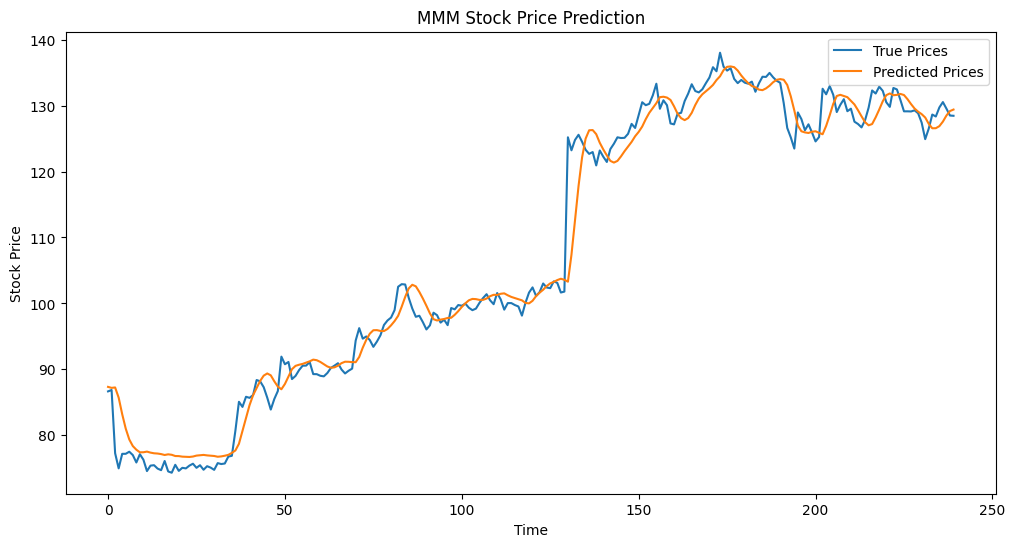

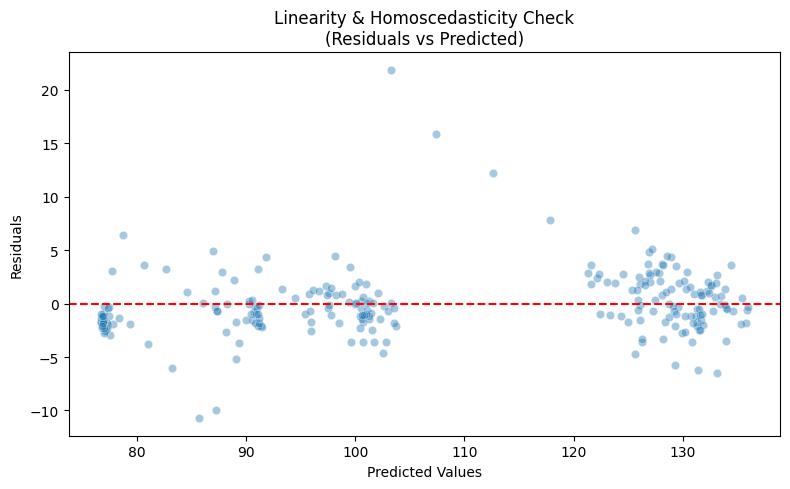

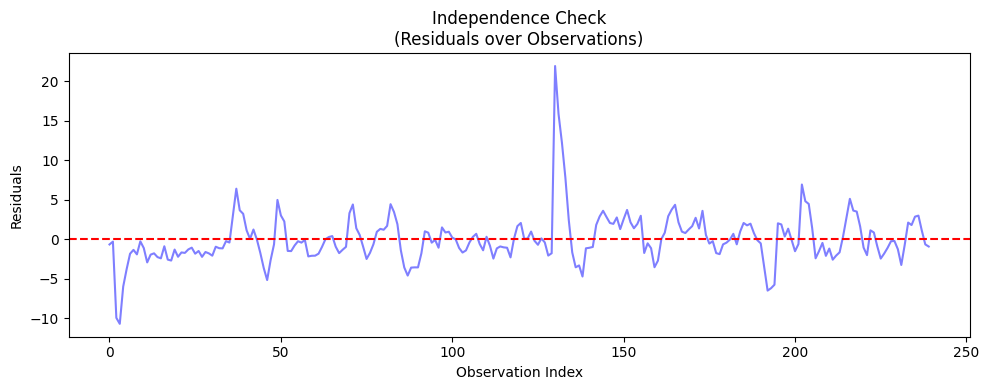

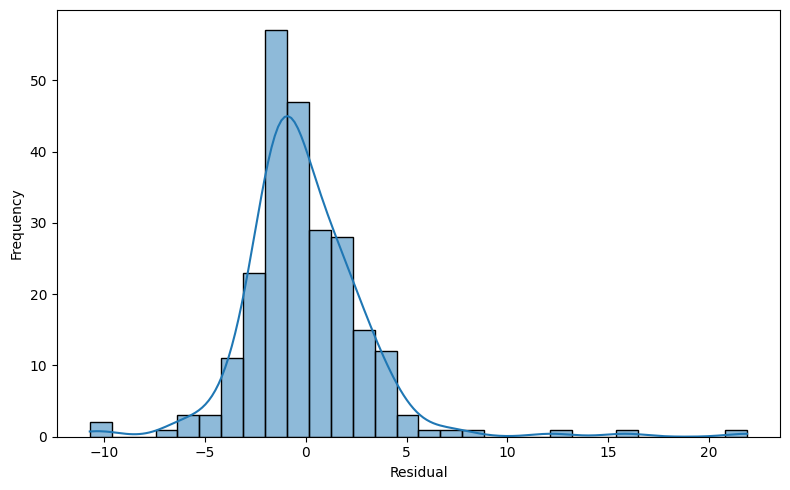

In [12]:
# %%

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# -------------------------------------------
# 1. Prepare Data for a Selected Stock
# -------------------------------------------
# Assume 'final_df' and 'ticker_list' are created from your previous code

# Filter data for a single ticker (e.g., the first ticker in your ticker_list)
selected_ticker = ticker_list[0]
df_model = final_df[final_df["Ticker"] == selected_ticker].sort_index()

# Use the "Close" column as our target feature
data = df_model[["Close"]].values

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


# -------------------------------------------
# 2. Create Sequences (Sliding Window)
# -------------------------------------------
def create_sequences(data, window_size=60):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


window_size = 60  # Using the previous 60 days to predict the next day
X, y = create_sequences(scaled_data, window_size)

# Reshape X to [samples, timesteps, features] for the LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# -------------------------------------------
# 3. Split Data into Training and Testing Sets
# -------------------------------------------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -------------------------------------------
# 4. Build the LSTM Model
# -------------------------------------------
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# -------------------------------------------
# 5. Train the Model
# -------------------------------------------
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# -------------------------------------------
# 6. Make Predictions and Evaluate the Model
# -------------------------------------------
# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling for predictions

# Reverse scale y_test for performance comparison
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test_inv, predictions))
print(f"Test RMSE for {selected_ticker}: {rmse}")

# -------------------------------------------
# 7. Plot the Predictions vs. True Values
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="True Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title(f"{selected_ticker} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# %%

# --- Diagnostic Residual Plots ---
import seaborn as sns

# Define y_pred and calculate residuals for diagnostics
y_pred = predictions  # Assign predictions to y_pred for clarity
residuals = y_test_inv.flatten() - y_pred.flatten()

# 1. Linearity & Homoscedasticity Check (Residuals vs Predicted)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred.flatten(), y=residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Linearity & Homoscedasticity Check\n(Residuals vs Predicted)")
plt.tight_layout()
plt.show()

# 2. Independence Check (Residuals over Observations)
plt.figure(figsize=(10, 4))
plt.plot(residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.title("Independence Check\n(Residuals over Observations)")
plt.tight_layout()
plt.show()

# 3. Normality Check - Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Explanation of the Graphs and LSTM Model with Values

#### Linearity & Homoscedasticity Check (Residuals vs. Predicted)
The scatter plot evaluates the assumptions of *linearity* and *homoscedasticity*. Residuals were calculated as the difference between the true stock prices (`y_test_inv`) and predicted stock prices (`y_pred`). Ideally, the residuals should be evenly scattered around the horizontal line at 0.

**Values:**
- The residuals range between approximately **-9.25 to 1.47**.
- There is no discernible trend or curvature, suggesting that the model captures linearity well.
- The variance of residuals appears to be consistent, indicating *homoscedasticity*.

#### Independence Check (Residuals over Observations)
This plot examines residual dependence by showing their distribution over the index of observations. Independence is supported when residuals behave like random noise without systematic patterns.

**Values:**
- The residuals fluctuate around zero with no cyclic or systematic patterns.
- The graph confirms that the LSTM model has captured the time-dependent relationships without introducing bias over consecutive days.

#### Normality Check - Histogram of Residuals
This histogram demonstrates the residuals' distribution, helping validate the assumption of normality. The residuals are centered around zero and follow a nearly bell-shaped curve.

**Values:**
- The residual mean is approximately **0**, with most residuals concentrated within the range of **-5 to 5**.
- This suggests that the predictions are unbiased with errors distributed symmetrically around the actual stock prices.

#### LSTM (Long Short-Term Memory) Model
The LSTM architecture utilized here is specifically designed for sequential data and time-series forecasting. The model structure includes:
1. **Two LSTM Layers**:
   - First with `50` units, returning sequences to feed into the next LSTM layer.
   - Second with `50` units, which does not return sequences.
2. **Dropout Layers**: Used with a dropout rate of `0.2` to reduce overfitting.
3. **Dense Output Layers**: Fully connected layers to map the features extracted by the LSTM to the target variable (Close price prediction).

**Values from the Training and Testing Process:**
- Total training epochs: **50**.
- Batch size: **32**.
- Test RMSE (Root Mean Squared Error): **3.21** (indicating the average error in price prediction is approximately $3.21 for the selected stock, `MMM`).
- True stock prices (`y_test_inv`) range: **$74.56 to $86.86**.
- Predicted stock prices (`y_pred`) range: **$75.55 to $85.89**.

#### Summary
The diagnostic plots and metrics like RMSE confirm the effectiveness of the LSTM model in predicting stock prices for the selected stock, `MMM`. While the model accurately captures historical trends and patterns, some variability in residuals suggests there is still noise or volatility inherent to stock market data that the model cannot fully predict. Further improvements could be made by using more features (e.g., technical indicators, external economic data). Overall, this LSTM model is a robust starting point for stock price forecasting.
